<a href="https://colab.research.google.com/github/ktbdls/Deep-Learning-Exploration-and-Interpretation-for-Skin-Lesion-Classification/blob/main/EfficientNetV2S_and_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
# libraries and tools
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

***Loading The Data***

In [ ]:
# load previously converted data
data = np.load('/content/drive/MyDrive/DISSERTATION/NEW/ISIC2018_images.npy',mmap_mode='r')
labels = np.load('/content/drive/MyDrive/DISSERTATION/NEW/ISIC2018_labels.npy',mmap_mode='r')

# print to viusualise shape
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (10015, 224, 224, 3)
Labels shape: (10015, 7)


***Further Preprocessing and Visualising***

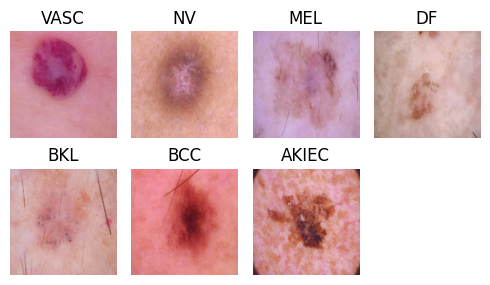

In [ ]:
# gather unique class labels and their corresponding indices in the npy array
unique_classes = np.unique(labels, axis=1)

# create a dictionary to store one data sample from each class
class_samples = {}

# add class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# select one data sample from each class to display
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# show images in 2 rows
plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

# print to check and visualise
plt.tight_layout()
plt.show()

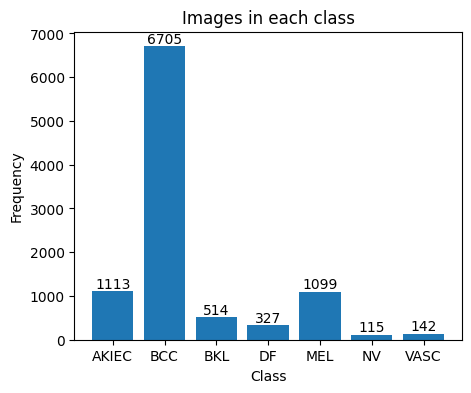

In [ ]:
# sum the one-hot encoded labels across the rows to calculate the frequency of each class
class_counts = np.sum(labels, axis=0)

# associate class indices with their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# plot the class frequencies for visual analysis of data spread
plt.figure(figsize=(5, 4))
plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

# annotate each bar with their class frequency (in integers)
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

In [ ]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

In [ ]:
# print to check split shapes
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)
# shows split 80/9/11

train_data shape: (8111, 224, 224, 3)
train_labels shape: (8111, 7)
val_data shape: (902, 224, 224, 3)
val_labels shape: (902, 7)
test_data shape: (1002, 224, 224, 3)
test_labels shape: (1002, 7)


In [ ]:
class_names_mapping = {
    0: "AKIEC",
    1: "BCC",
    2: "BKL",
    3: "DF",
    4: "MEL",
    5: "NV",
    6: "VASC"
}
# calculate class distribution of the sets
num_classes = train_labels.shape[1]
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

class_counts_mapping = {}
for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name] = {'Train': class_counts_train[index]}

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Validation'] = class_counts_val[index]

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Test'] = class_counts_test[index]

# print to visualise for each set
for class_name, counts in class_counts_mapping.items():
    print(class_name)
    for set_name, count in counts.items():
        print(f" - {set_name}: {count}")

# BCC has the highest - highly imbalanced

AKIEC
 - Train: 902.0
 - Validation: 100.0
 - Test: 111.0
BCC
 - Train: 5430.0
 - Validation: 604.0
 - Test: 671.0
BKL
 - Train: 417.0
 - Validation: 46.0
 - Test: 51.0
DF
 - Train: 264.0
 - Validation: 30.0
 - Test: 33.0
MEL
 - Train: 890.0
 - Validation: 99.0
 - Test: 110.0
NV
 - Train: 93.0
 - Validation: 10.0
 - Test: 12.0
VASC
 - Train: 115.0
 - Validation: 13.0
 - Test: 14.0


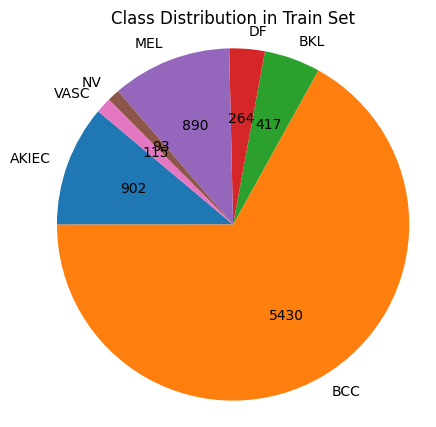

In [ ]:
# make visual pie charts
for set_name in ['Train']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal') # a circle
    plt.show()

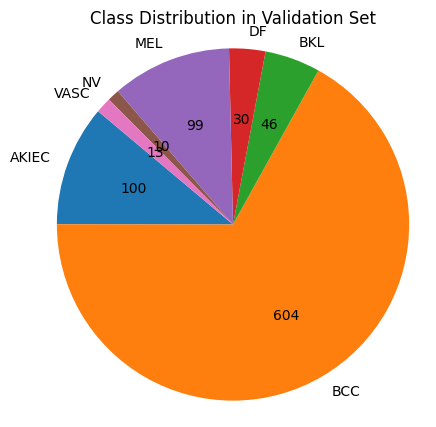

In [ ]:
# make visual pie charts
for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal') # a circle
    plt.show()

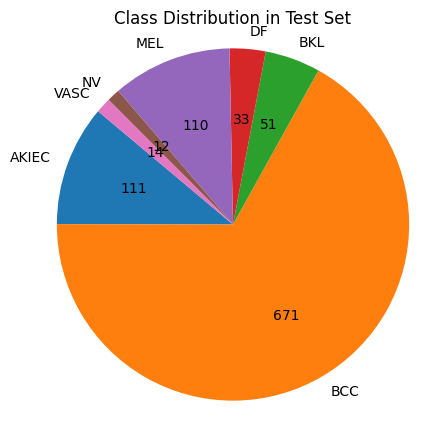

In [ ]:
# make visual pie charts
for set_name in ['Test']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal') # a circle
    plt.show()

***Augmenting The Data***

In [ ]:
# data augmentation during training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

***Building The Model***

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=1e-4, verbose=1)
saved_model = '/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras'
model_chkpt = ModelCheckpoint(saved_model, save_best_only=True, monitor='val_accuracy', verbose=1)

# list of callbacks
callback_list = [model_chkpt, lr_reduce]

In [ ]:
base_model = EfficientNetV2S(weights='imagenet',
                             include_top=False,
                             input_shape=(224, 224, 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # bridge CNN to fully connected layers
x = Dense(128, activation='relu')(x) # relu activation fuction for added layers ontop of CNN - great for learing complex patterns in the image data
x = Dropout(0.5)(x) # prevent overfitting
predictions = Dense(7, activation='softmax')(x)  # 7 classes to output with softmax to put each raw output score into its probable class

# create the final model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)


# compile model with adam optimiser
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 50
batch_size = 16

***Training The Model***

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6417 - loss: 1.0427
Epoch 1: val_accuracy improved from -inf to 0.67073, saving model to /content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 384s 434ms/step - accuracy: 0.6417 - loss: 1.0425 - val_accuracy: 0.6707 - val_loss: 1.0991 - learning_rate: 0.0010
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7152 - loss: 0.7933
Epoch 2: val_accuracy did not improve from 0.67073
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.7152 - loss: 0.7933 - val_accuracy: 0.6696 - val_loss: 1.2212 - learning_rate: 0.0010
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7365 - loss: 0.7231
Epoch 3: val_accuracy did not improve from 0.67073
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.7365 - loss: 0.7231 - val_accuracy: 0.6707 - val_loss: 7.4159 - learning_rate: 0.0010
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7517 - lo

In [ ]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

In [ ]:
epochs = 10

***Retraining***

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9825 - loss: 0.0477
Epoch 1: val_accuracy did not improve from 0.87361
507/507 ━━━━━━━━━━━━━━━━━━━━ 305s 345ms/step - accuracy: 0.9825 - loss: 0.0477 - val_accuracy: 0.8636 - val_loss: 0.7103 - learning_rate: 1.0000e-04
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9855 - loss: 0.0432
Epoch 2: val_accuracy did not improve from 0.87361
507/507 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.9855 - loss: 0.0432 - val_accuracy: 0.8426 - val_loss: 0.9837 - learning_rate: 1.0000e-04
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9883 - loss: 0.0334
Epoch 3: val_accuracy did not improve from 0.87361
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.9883 - loss: 0.0334 - val_accuracy: 0.8160 - val_loss: 1.3461 - learning_rate: 1.0000e-04
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9911 - loss: 0.0284
Epoch 4: val_accuracy did not improve from 0.87361

In [ ]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

In [ ]:
epochs = 5

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9886 - loss: 0.0380
Epoch 1: val_accuracy did not improve from 0.87361
507/507 ━━━━━━━━━━━━━━━━━━━━ 309s 351ms/step - accuracy: 0.9886 - loss: 0.0380 - val_accuracy: 0.8392 - val_loss: 0.7619 - learning_rate: 1.0000e-04
Epoch 2/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9906 - loss: 0.0298
Epoch 2: val_accuracy did not improve from 0.87361
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9906 - loss: 0.0298 - val_accuracy: 0.8492 - val_loss: 0.9487 - learning_rate: 1.0000e-04
Epoch 3/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9862 - loss: 0.0428
Epoch 3: val_accuracy did not improve from 0.87361
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9862 - loss: 0.0428 - val_accuracy: 0.8370 - val_loss: 0.9777 - learning_rate: 1.0000e-04
Epoch 4/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9898 - loss: 0.0321
Epoch 4: val_accuracy did not improve from 0.87361
507

In [ ]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

***Testing The Model on Unseen Data***

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 332ms/step - accuracy: 0.8899 - loss: 0.5549
Test Accuracy: 0.871257483959198


In [ ]:
# use test data to get predictions
predictions = model.predict(test_data)

# convert preds to int values
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# gather report
report = classification_report(true_labels, predicted_labels)

# print for visual
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       111
           1       0.93      0.95      0.94       671
           2       0.80      0.76      0.78        51
           3       0.85      0.67      0.75        33
           4       0.73      0.67      0.70       110
           5       0.58      0.58      0.58        12
           6       1.00      0.93      0.96        14

    accuracy                           0.87      1002
   macro avg       0.80      0.76      0.78      1002
weighted avg       0.87      0.87      0.87      1002



In [ ]:
# get the numbers for confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[ 81,  19,   2,   0,   7,   2,   0],
       [ 20, 637,   3,   0,  10,   1,   0],
       [  0,   8,  39,   0,   4,   0,   0],
       [  3,   1,   3,  22,   4,   0,   0],
       [  9,  21,   2,   2,  74,   2,   0],
       [  1,   0,   0,   2,   2,   7,   0],
       [  0,   1,   0,   0,   0,   0,  13]])

Normalized confusion matrix


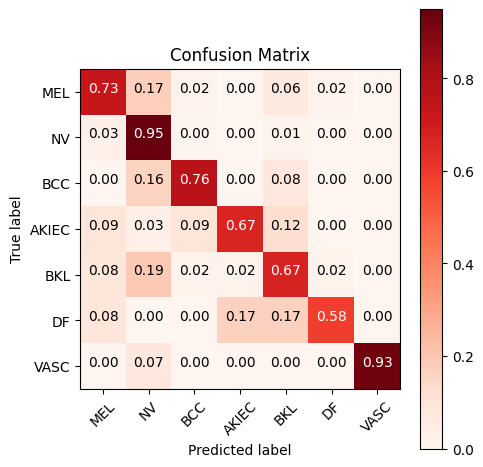

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


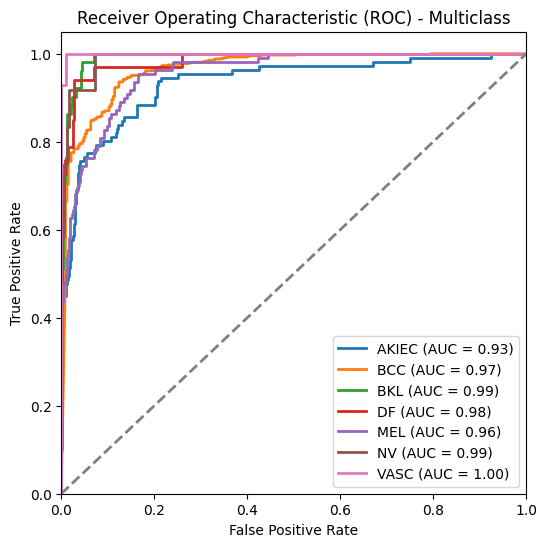

In [ ]:
# names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# use prediction data
predictions = model.predict(test_data)

# no. of classes
num_classes = test_labels.shape[1]

# plot size
plt.figure(figsize=(6, 6))

# loop through for each of the classes
for class_index in range(num_classes):
    # calc ROC curve and ROC AUC for the specific class
    fpr, tpr, thresholds = roc_curve(test_labels[:, class_index], predictions[:, class_index])
    roc_auc = auc(fpr, tpr)

    # plot it
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

# plot diagonal line to see if the model is performing better than "random"
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# graph properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')

plt.show()

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 1 GPUs


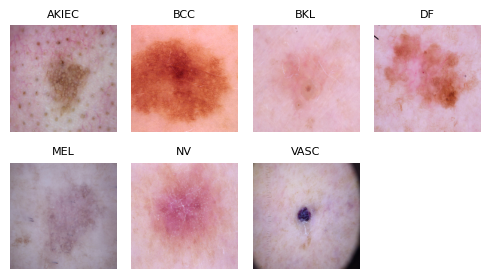

In [ ]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# convert to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# find the indices of the first image from each class
class_indices = [np.where(test_labels_int == i)[0][0] for i in range(len(image_titles))]

# store the images
image_array = []

# subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # predicted images test data
    img = test_data[class_indices[i]]
    image_array.append(img)  # add to store

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

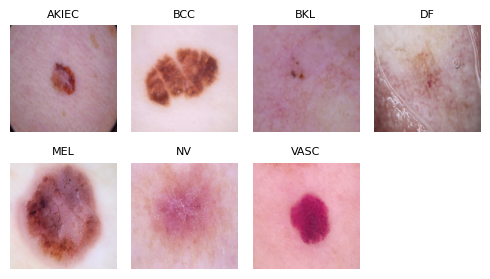

In [ ]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# convert to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# store the images
image_array = []

# subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # find indices of images for specific class
    class_indices = np.where(test_labels_int == i)[0]
    random_index = np.random.choice(class_indices)  # define random index

    # predicted images test data
    img = test_data[random_index]
    image_array.append(img)  # store

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

In [ ]:
replace2linear = ReplaceToLinear()


In [ ]:
score = CategoricalScore([0, 1, 2, 3, 4, 5, 6])

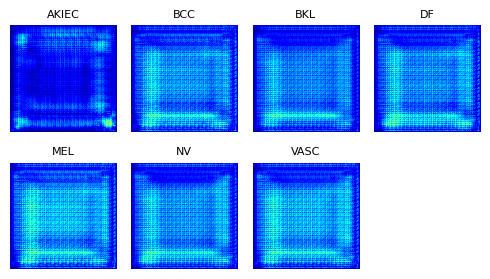

CPU times: user 25.7 s, sys: 505 ms, total: 26.3 s
Wall time: 26.3 s


In [ ]:
%%time
from keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # no. of calculating gradients iterations
                        smooth_noise=0.20) # how much the noise is spread

# subplot features
num_rows = 2
num_cols = (num_images + 1) // num_rows

# rendering
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(saliency_map[i], cmap='jet')
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

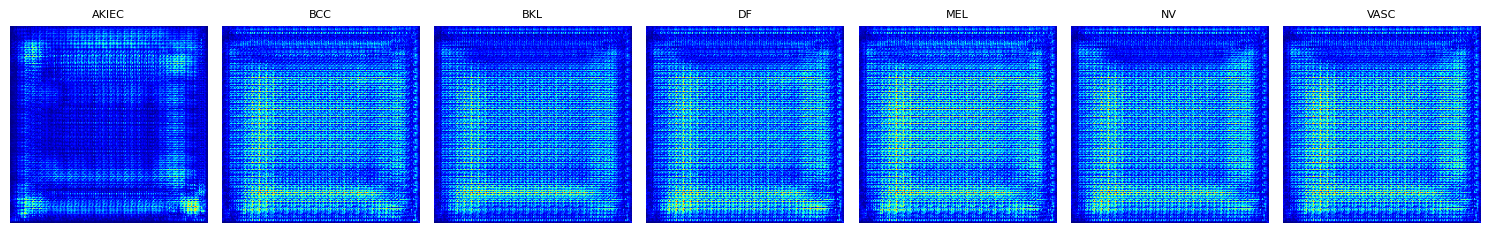

CPU times: user 22.7 s, sys: 412 ms, total: 23.1 s
Wall time: 22.7 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_maps = saliency(score, X, smooth_samples=20, smooth_noise=0.20)

# no. of images
num_images = len(image_titles)

# one row instead of 2 this time
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

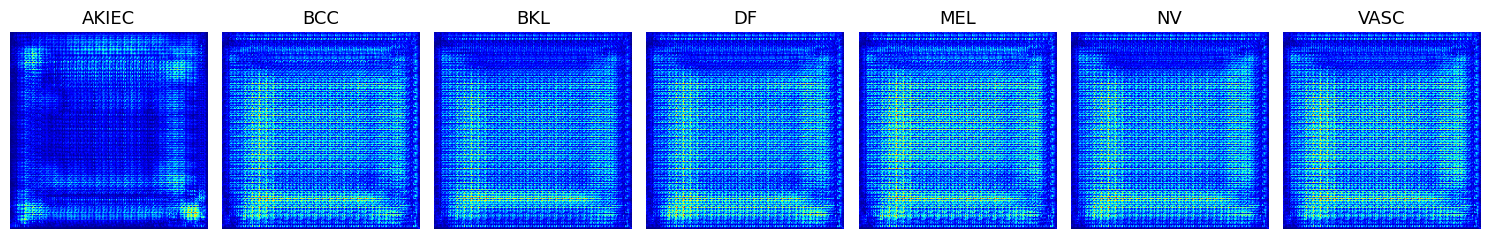

CPU times: user 22.6 s, sys: 430 ms, total: 23 s
Wall time: 22.6 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_maps = saliency(score,
                         X,
                         smooth_samples=20,
                         smooth_noise=0.20)

# no. of images
num_images = len(image_titles)

# one row
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    axes[i].set_title(title, fontsize=13)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# model.summary()

# # Alternatively, to print only convolutional layers:
# for layer in model.layers:
#     if 'conv' in layer.name:
#         print(layer.name)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 61,180,951 (233.39 MB)

 Trainable params: 20,342,359 (77.60 MB)

 Non-trainable params: 153,872 (601.06 KB)

 Optimizer params: 40,684,720 (155.20 MB)

stem_conv
block1a_project_conv
block1b_project_conv
block2a_expand_conv
block2a_project_conv
block2b_expand_conv
block2b_project_conv
block2c_expand_conv
block2c_project_conv
block2d_expand_conv
block2d_project_conv
block3a_expand_conv
block3a_project_conv
block3b_expand_conv
block3b_project_conv
block3c_expand_conv
block3c_project_conv
block3d_expand_conv
block3d_project_conv
block4a_expand_conv
block4a_dwconv2
block4a_project_conv
block4b_expand_conv
block4b_dwconv2
block4b_project_conv
block4c_expand_conv
block4c_dwconv2
block4c_project_conv
block4d_expand_conv
block4d_dwconv2
block4d_project_conv
block4e_expand_conv
block4e_dwconv2
block4e_project_conv
block4f_expand_conv
block4f_dwconv2
block4f_project_conv
block5a_expand_conv
block5a_dwconv2
block5a_project_conv
block5b_expand_conv
block5b_dwconv2
block5b_project_conv
block5c_expand_conv
block5c_dwconv2
block5c_project_conv
block5d_expand_conv
block5d_dwconv2
block5d_project_conv
block5e_expand_conv
block5e_dwconv2
block5e_projec

In [ ]:
# # Get model's prediction confidence for all images
# model_output = model.predict(X)

# # Print out the confidence for each class for each image
# for i, prediction in enumerate(model_output):
#     print(f"Image {i}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Image 0: [0. 1. 0. 0. 0. 0. 0.]
Image 1: [0. 1. 0. 0. 0. 0. 0.]
Image 2: [0. 1. 0. 0. 0. 0. 0.]
Image 3: [0. 1. 0. 0. 0. 0. 0.]
Image 4: [0. 1. 0. 0. 0. 0. 0.]
Image 5: [0. 1. 0. 0. 0. 0. 0.]
Image 6: [0. 1. 0. 0. 0. 0. 0.]


In [ ]:
# # Check the model's predictions for the input images
# model_output = model.predict(X)

# # Print the confidence for each class for each image
# for i, prediction in enumerate(model_output):
#     print(f"Image {i} Predictions: {prediction}")
#     print(f"Class with max confidence: {np.argmax(prediction)}")

# # Get the distribution of predicted classes
# predicted_classes = np.argmax(model_output, axis=1)
# unique, counts = np.unique(predicted_classes, return_counts=True)
# class_distribution = dict(zip(unique, counts))

# print(f"Predicted class distribution: {class_distribution}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 0 Predictions: [0. 1. 0. 0. 0. 0. 0.]
Class with max confidence: 1
Image 1 Predictions: [0. 1. 0. 0. 0. 0. 0.]
Class with max confidence: 1
Image 2 Predictions: [0. 1. 0. 0. 0. 0. 0.]
Class with max confidence: 1
Image 3 Predictions: [0. 1. 0. 0. 0. 0. 0.]
Class with max confidence: 1
Image 4 Predictions: [0. 1. 0. 0. 0. 0. 0.]
Class with max confidence: 1
Image 5 Predictions: [0. 1. 0. 0. 0. 0. 0.]
Class with max confidence: 1
Image 6 Predictions: [0. 1. 0. 0. 0. 0. 0.]
Class with max confidence: 1
Predicted class distribution: {1: 7}


In [ ]:
# # Assuming `y_train` contains your training labels
# unique, counts = np.unique(train_labels, return_counts=True)
# class_distribution = dict(zip(unique, counts))

# print(f"Training set class distribution: {class_distribution}")

Training set class distribution: {0.0: 48666, 1.0: 8111}


11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


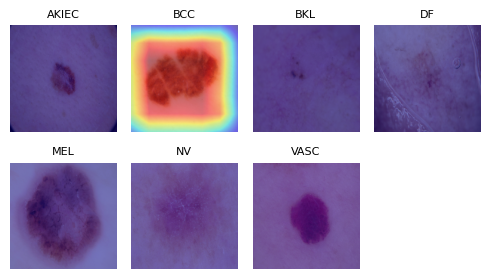

CPU times: user 40.2 s, sys: 818 ms, total: 41 s
Wall time: 33.1 s


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam

# create scorecam variable
scorecam = Scorecam(model, model_modifier=replace2linear)

# implement faster scorecam parameters
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

# subplot features
num_rows = 2
num_cols = (num_images + 1) // num_rows

# rendering
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(image_array[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

In [ ]:
# %%time
# from matplotlib import pyplot as plt, cm
# from tf_keras_vis.scorecam import Scorecam

# # Assuming you have already defined model and replace2linear

# # Create ScoreCAM object
# scorecam = Scorecam(model, model_modifier=replace2linear)

# # Generate heatmaps with Faster-ScoreCAM
# cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# # Calculate the number of images
# num_images = len(image_titles)

# # Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

#     combined_image = cv2.addWeighted(image_array[i], 0.5, heatmap, 0.5, 0)

#     axes[i].set_title(title, fontsize=8)
#     axes[i].imshow(combined_image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step


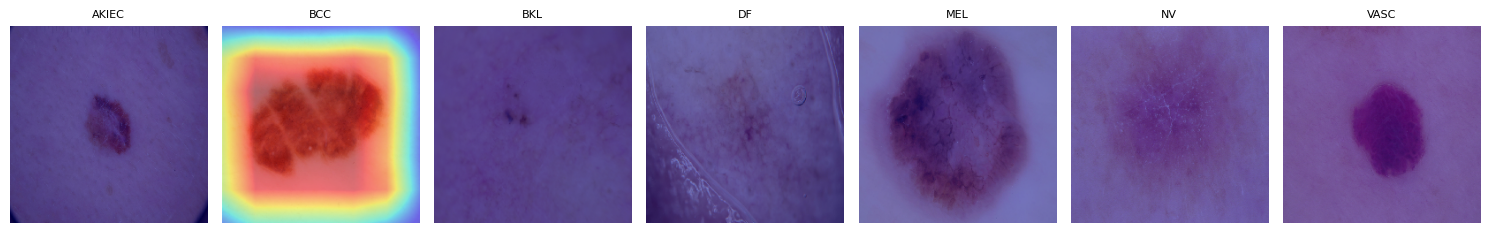

CPU times: user 26.8 s, sys: 754 ms, total: 27.6 s
Wall time: 26.6 s


In [ ]:
%%time
from matplotlib import pyplot as plt, cm
from tf_keras_vis.scorecam import Scorecam
import cv2
import numpy as np

# scorecam variable
scorecam = Scorecam(model, model_modifier=replace2linear)

# use faster scorecam parameters with higher max_N
cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# no. of images
num_images = len(image_titles)

# single row
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    # convert image_array[i] to uint8 to match heatmap data type
    image = np.uint8(image_array[i] * 255)

    combined_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(combined_image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()